<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/1.2_EDA_VarIndex(veraltet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Verbinden mit der Google Drive und Import der benötigten Module:

In [1]:
# Verbinden mit der Google-Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import io, os, sys, setuptools, tokenize

In [3]:
!pip install pvlib

In [4]:
## import modules

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pvlib

from datetime import datetime
from datetime import timedelta
from prophet import Prophet
from math import sqrt

from scipy.fft import fft

In [5]:
# Größe der Plots festlegen
matplotlib.rcParams['figure.figsize'] = (13, 8)

In [6]:
latitude = 50.2
longitude = 7.8

seconds_in_day = 24*60*60
seconds_in_year = (365.2425)*seconds_in_day

tz, altitude, name = 'Europe/Berlin', 70, 'SanktAugustin'
tus = pvlib.location.Location(latitude, longitude, tz, altitude, name)

In [7]:
# Pfad zur CSV-Datei auf Google Drive
name_Messwerte = 'UVI_Messdaten.csv'
name_Vorhersage = 'Vorhersage.csv'
name_Solar_Messwerte = 'Solys_Messdaten.csv'
drive_path = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'
output_plot_path = '/content/drive/My Drive/Colab_Notebooks/plot_daily_UVI/'

In [8]:
# Import der Daten für die EDA
df_UVI = pd.read_csv(drive_path + name_Messwerte)
df_Solys = pd.read_csv(drive_path + name_Solar_Messwerte)
df_CAMS = pd.read_csv(drive_path + name_Vorhersage)

# Messzeitpunkt in Datetime umwandeln
df_UVI.set_index('Datetime', inplace=True)
df_Solys.set_index('Datetime', inplace=True)
df_CAMS.set_index('Datetime', inplace=True)

# Index in Datetime umwandeln
df_UVI.index = pd.to_datetime(df_UVI.index)
df_Solys.index = pd.to_datetime(df_Solys.index)
df_CAMS.index = pd.to_datetime(df_CAMS.index)

# NaN Einträge durch 0 ersetzen
df_UVI['UVI'] = df_UVI['UVI'].fillna(0)
df_UVI['erythem'] = df_UVI['erythem'].fillna(0)
df_Solys.dropna(inplace = True)

In [9]:
# Die Glo Spalte in den Solys-Daten in ghi umbenennen
df_rad = []
df_rad = df_Solys['Glo'].copy()
df_rad = pd.DataFrame({'ghi': df_rad})

In [10]:
df_rad.replace(0, np.nan, inplace=True)
# Entfernen aller Zeilen mit NaN-Werten
df_rad.dropna(inplace=True)

In [11]:
# Gruppieren des Dataframes nach Stunde - nur die ersten 1000 Datenpunkte
stundliche_gruppe = df_rad.groupby([df_rad.index.date, df_rad.index.hour])

In [12]:
# Stündlicher Durchschitt ohne Nullen
df_UVI_hourly = df_UVI[df_UVI['UVI'] != 0][['UVI','erythem', 'SZA']].resample('H').mean()

In [13]:
# Stündlicher Durchschitt mit Nullen
df_UVI_hourly_withZero = df_UVI[['UVI','erythem', 'SZA']].resample('H').mean()

## Skartveit Klassifikator:

### Funktionen:

In [14]:
# Klasse für den Klassifokator

def sigma_skartveit_GHI(rad_df, cs):
    # Index nach Skarveit
    # berechnen des Variabiltätsindex sigma_skarveit_GHI mit Hilfe der Globalstrahlung
        """
        Eq. (3.1)
        paper uses DNI values. Here GHI
        can reach values above 1
        Skartveit A., J.A. Olseth, M.E. Tuft, 1998: An hourly
        diffuse fraction model with correction for variability
        and surface albedo. – Sol. Energy 63, 173–183, DOI:
        10.1016/S0038-092X(98)00067-X.

        Returns
        -------
        sigma_skartveit

        """
        # tus = pvlib.location.Location(latitude, longitude, tz, altitude, name)

        # kc = Clear-Sky-Index | kc_t_m1 = Clear-Sky-Index of previus hour | kc_t_p1 = Clear-Sky-Index following hour
        kc = []
        kc_t_m1 = []
        kc_t_p1 = []
        i = 0

        # füllen von kc | kc_t_m1 | kc_t_p1
        for i in range(1,len(rad_df['ghi'])-1):
            kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
            kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
            kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])

        # Berechnung der arthmetischen Mittelwerte
        kc = np.array(kc).mean()
        kc_t_m1 = np.array(kc_t_m1).mean()
        kc_t_p1 = np.array(kc_t_p1).mean()

        # Umsetzung der Gleichung 3.1 für die GHI
        return sqrt((((kc-kc_t_m1)**2)+((kc-kc_t_p1)**2))/2)

In [15]:
def V_combria_GHI(rad_df, cs):
        # Index nach Combria
        # Standardabweichung der zeitlichen Unterschiede von Kc
        """
        Eq. (3.2)
        paper uses DNI values. Here GHI
        can reach values above 1
        Coimbra, C.F.M., J. Kleissl, R. Marquez, 2013: Overview of
        Solar-Forecasting Methods and a Metric for Accuracy Evaluation. – In: Kleissl, J. (Ed.): Solar Energy Forecasting and
        Resource Assessment. Oxford, 171–194.

        Returns
        -------
        V

        """
        V=0
        i=0
        kc = []
        kc_t_p1 = []
        delta_kc = []


        for i in range(len(rad_df['ghi'])-1):
            kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
            kc_t_p1 = rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1]
            delta_kc = kc-kc_t_p1
            V = V+(delta_kc)**2

        # Umsetzung der Gleichung 3.2 für die GHI
        return sqrt(V/(i+1)), kc

In [16]:
def VI_stein_GHI(rad_df, cs):
        # Index nach Stein
        """
        Eq. (3.2)
        paper uses DNI values. Here GHI
        can reach values above 1
        Stein, J.S., M.J. Reno, C. Hansen, 2012: The variability index: a new and novel metric for quantifying irradiance and
        PV output variability. – In: World Renewable Energy Forum,
        Denver, CO.

        Returns
        -------
        VI
        """

        summe1 = sum(((rad_df['ghi'].diff().dropna()**2)+1)**(1/2))
        summe2 = sum(((cs['ghi'].diff().dropna()**2)+1)**(1/2))

        # Bedingte Überprüfung und Zuweisung
        ergebnis = summe1 / summe2 if summe2 != 0 else np.nan

        return ergebnis

### Funktionsaufruf:

In [18]:
df_std_ind = pd.DataFrame()
df_temp = pd.DataFrame()
stundliche_indizes = []
Messpunkt = []

for datum, gruppe in stundliche_gruppe:
    if not gruppe.empty:  # Überprüfen, ob die Gruppe Daten enthält

        cs = tus.get_clearsky(gruppe.index)

        index_sigma = sigma_skartveit_GHI(gruppe, cs)
        index_coimbra, kc = V_combria_GHI(gruppe, cs)
        index_stein = VI_stein_GHI(gruppe, cs)

        df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
                                          , 'index_stein': index_stein, 'kc' : kc}, ignore_index=True)

        # df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra}, ignore_index=True)

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:40: RuntimeWarning: invalid value encountered in scalar subtract
  return sqrt((((kc-kc_t_m1)**2)+((kc-kc_t_p1)**2))/2)
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-15-b1482d70cd78>:26: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1 = rad_df['ghi']

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-88

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-88

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:35: RuntimeWarning: Mean of empty slice.
  kc = np.array(kc).mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-8847c5710c6a>:36: RuntimeWarning: Mean of empty slice.
  kc_t_m1 = np.array(kc_t_m1).mean()
<ipython-input-14-8847c5710c6a>:37: RuntimeWarning: Mean of empty slice.
  kc_t_p1 = np.array(kc_t_p1).mean()
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-88

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:35: RuntimeWarning: Mean of empty slice.
  kc = np.array(kc).mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-8847c5710c6a>:36: RuntimeWarning: Mean of empty slice.
  kc_t_m1 = np.array(kc_t_m1).mean()
<ipython-input-14-8847c5710c6a>:37: RuntimeWarning: Mean of empty slice.

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-in

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-88

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-88

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])
<ipython-input-14-8847c5710c6a>:40: RuntimeWarning: invalid value encountered in scalar subtract
  return sqrt((((kc-kc_t_m1)**2)+((kc-kc_t_p1)**2))/2)
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-15-b1482d70cd78>:26: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1 = rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1]
<ipython-input-15-b1482d70cd78>:27: RuntimeWarning: invalid value encountered in scalar 

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:35: RuntimeWarning: Mean of empty slice.
  kc = np.array(kc).mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: R

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])
<ipython-input-14-8847c5710c6a>:40: RuntimeWarning: invalid value encountered in scalar subtract
  return sqrt((((kc-kc_t_m1)**2)+((kc-kc_t_p1)**2))/2)
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-15-b1482d70cd78>:26: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1 = rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1]
<ipython-input-15-b1482d70cd78>:27: RuntimeWarning: invalid value encountered in scalar 

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:40: RuntimeWarning: invalid value encountered in scalar subtract
  return sqrt((((kc-kc_t_m1)**2)+((kc-kc_t_p1)**2))/2)
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-15-b1482d70cd78>:26: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1 = rad_df['ghi']

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])
<ipython-input-15-b1482d70cd78>:26: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1 = rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1]
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:40: RuntimeWarning: invalid value encountered in scalar subtract
  return 

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:40: RuntimeWarning: invalid value encountered in scalar subtract
  return sqrt((((kc-kc_t_m1)**2)+((kc-kc_t_p1)**2))/2)
<ipython-input-15-b1482d70cd78>:26: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1 = rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1]
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-15-b1482d70cd78>:27: RuntimeWarning: invalid value encountered in scalar subtract
  delta_kc = kc-kc_t_p1
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])
<ipython-input-15-b1482d70cd78>:26: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1 = rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1]
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:40: RuntimeWarning: invalid value encountered in scalar subtract
  return sqrt((((kc-kc_t_m1)**2)+((kc-kc_t_p1)**2))/2)
<ipython-input-15-b1482d70cd78>:26: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1 = rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1]
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-15-b1482d70cd78>:27: RuntimeWarning: invalid value encountered in scalar 

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:40: RuntimeWarning: invalid value encountered in scalar subtract
  return sqrt((((kc-kc_t_m1)**2)+((kc-kc_t_p1)**2))/2)
<ipython-input-15-b1482d70cd78>:26: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1 = rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1]
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-15-b1482d70cd78>:27: RuntimeWarning: invalid value encountered in scalar 

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-15-b1482d70cd78>:26: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1 = rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1]
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-15-b1482d70cd78>:27: RuntimeWarning: invalid value encountered in scalar subtract
  delta_kc = kc-kc_t_p1
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipyth

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])
<ipython-input-14-8847c5710c6a>:40: RuntimeWarning: invalid value encountered in scalar subtract
  return sqrt((((kc-kc_t_m1)**2)+((kc-kc_t_p1)**2))/2)
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-15-b1482d70cd78>:26: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1 = rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1]
<ipython-input-15-b1482d70cd78>:27: RuntimeWarning: invalid value encountered in scalar 

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:40: RuntimeWarning: invalid value encountered in scalar subtract
  return sqrt((((kc-kc_t_m1)**2)+((kc-kc_t

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])
<ipython-in

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])
<ipython-input-14-8847c5710c6a>:40: RuntimeWarning: invalid value encountered in scalar subtract
  return sqrt((((kc-kc_t_m1)**2)+((kc-kc_t_p1)**2))/2)
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-15-b1482d70cd78>:26: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1 = rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1]
<ipython-input-15-b1482d70cd78>:27: RuntimeWarning: invalid value encountered in scalar 

<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:40: RuntimeWarning: invalid value encountered in scalar subtract
  return sqrt((((kc-kc_t_m1)**2)+((kc-kc_t_p1)**2))/2)
<ipython-input-15-b1482d70cd78>:26: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1 = rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1]
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-15-b1482d70cd78>:27: RuntimeWarning: invalid value encountered in scalar subtract
  delta_kc = kc-kc_t_p1
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:40: RuntimeWarning: invalid value encountered in scalar subtract
  return sqrt((((kc-kc_t_m1)**2)+((kc-kc_t

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])
<ipython-input-15-b1482d70cd78>:26: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1 = rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1]
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['gh

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])
<ipython-in

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])
<ipython-input-15-b1482d70cd78>:26: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1 = rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1]
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:40: RuntimeWarning: invalid value encountered in scalar subtract
  return sqrt((((kc-kc_t_m1)**2)+((kc-kc_t_p1)**2))/2)
<ipython-input-15-b1482d70cd78>:26: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1 = rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1]
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-15-b1482d70cd78>:27: RuntimeWarning: invalid value encountered in scalar 

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-88

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-88

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-88

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-88

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:40: RuntimeWarning: invalid value encountered in scalar subtract
  return sqrt((((kc-kc_t_m1)**2)+((kc-kc_t

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:35: RuntimeWarning: Mean of empty slice.
  kc = np.array(kc).mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-8847c5710c6a>:36: RuntimeWarning: Mean of empty slice.
  kc_t_m1 = np.array(kc_t_m1).mean()
<ipython-input-14-8847c5710c6a>:37: RuntimeWarning: Mean of empty slice.
  kc_t_p1 = np.array(kc_t_p1).mean()
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-14-8847c5710c6a>:35: RuntimeWarning: Mean of empty slice.
  kc = np.array(kc).mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-8847c5710c6a>:36: RuntimeWarning: Mean of empty slice.
  kc_t_m1 = np.array(kc_t_m1).mean()
<ipython-input-14-8847c5710c6a>:37: RuntimeWarning: Mean of empty slice.
  kc_t_p1 = np.array(kc_t_p1).mean()
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra


<ipython-input-14-8847c5710c6a>:35: RuntimeWarning: Mean of empty slice.
  kc = np.array(kc).mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-8847c5710c6a>:36: RuntimeWarning: Mean of empty slice.
  kc_t_m1 = np.array(kc_t_m1).mean()
<ipython-input-14-8847c5710c6a>:37: RuntimeWarning: Mean of empty slice.
  kc_t_p1 = np.array(kc_t_p1).mean()
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:35: RuntimeWarning: Mean of empty slice.
  kc = np.array(kc).mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-8847c5710c6a>:36: RuntimeWarning: Mean of empty slice.
  kc_t_m1 = np.array(kc_t_m1).mean()
<ipython-input-14-8847c5710c6a>:37: RuntimeWarning: Mean of empty slice.

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-14-8847c5710c6a>:35: RuntimeWarning: Mean of empty slice.
  kc = np.array(kc).mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-8847c5710c6a>:36: RuntimeWarning: Mean of empty slice.
  kc_t_m1 = np.array(kc_t_m1).mean()
<ipython-input-14-8847c5710c6a>:37: RuntimeWarning: Mean of empty slice.
  kc_t_p1 = np.array(kc_t_p1).mean()
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:35: RuntimeWarning: Mean of empty slice.
  kc = np.array(kc).mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: R

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:35: RuntimeWarning: Mean of empty slice.
  kc = np.array(kc).mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-8847c5710c6a>:36: RuntimeWarning: Mean of empty slice.
  kc_t_m1 = np.array(kc_t_m1).mean()
<ipython-input-14-8847c5710c6a>:37: RuntimeWarning: Mean of empty slice.
  kc_t_p1 = np.array(kc_t_p1).mean()
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:35: RuntimeWarning: Mean of empty slice.
  kc = np.array(kc).mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-8847c5710c6a>:36: RuntimeWarning: Mean of empty slice.
  kc_t_m1 = np.array(kc_t_m1).mean()
<ipython-input-14-8847c5710c6a>:37: RuntimeWarning: Mean of empty slice.
  kc_t_p1 = np.array(kc_t_p1).mean()
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:35: RuntimeWarning: Mean of empty slice.
  kc = np.array(kc).mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: R

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])
<ipython-input-14-8847c5710c6a>:40: RuntimeWarning: invalid value encountered in scalar subtract
  return sqrt((((kc-kc_t_m1)**2)+((kc-kc_t_p1)**2))/2)
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-15-b1482d70cd78>:26: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1 = rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1]
<ipython-input-15-b1482d70cd78>:27: RuntimeWarning: invalid value encountered in scalar 

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-88

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])
<ipython-input-14-8847c5710c6a>:40: RuntimeWarning: invalid value encountered in scalar subtract
  return sqrt((((kc-kc_t_m1)**2)+((kc-kc_t_p1)**2))/2)
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])
<ipython-input-14-8847c5710c6a>:40: RuntimeWarning: invalid value encountered in scalar subtract
  return sqrt((((kc-kc_t_m1)**2)+((kc-kc_t_p1)**2))/2)
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])
<ipython-input-14-8847c5710c6a>:40: RuntimeWarning: invalid value encountered in scalar subtract
  return sqrt((((kc-kc_t_m1)**2)+((kc-kc_t_p1)**2))/2)
<ipython-input-15-b1482d70cd78>:25: RuntimeWarning: divide by zero encountered in scalar divide
  kc = rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i]
<ipython-input-15-b1482d70cd78>:26: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1 = rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1]
<ipython-input-15-b1482d70cd78>:27: RuntimeWarning: invalid value encountered in scalar 

<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-18-a6ccdcdc3a28>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'index_sigma': index_sigma, 'index_coimbra': index_coimbra
<ipython-input-14-8847c5710c6a>:30: RuntimeWarning: divide by zero encountered in scalar divide
  kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
<ipython-input-14-8847c5710c6a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
<ipython-input-14-8847c5710c6a>:32: RuntimeWarning: divide by zero encountered in scalar divide
  kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs

## Nachbearbeitung der Dataframes:

In [19]:
null_in_spalte_a = df_rad[df_rad['ghi'].isnull()].index.tolist()
print(null_in_spalte_a, df_rad['ghi'])

[] Datetime
2022-06-15 07:21:00    554.483333
2022-06-15 07:23:00    557.791667
2022-06-15 07:25:00    561.708333
2022-06-15 07:27:00    564.783333
2022-06-15 07:29:00    571.850000
                          ...    
2023-08-19 05:48:00    232.516667
2023-08-19 05:50:00    233.466667
2023-08-19 05:52:00    215.358333
2023-08-19 05:54:00    215.333333
2023-08-19 05:56:00    169.541667
Name: ghi, Length: 94260, dtype: float64


In [20]:
df_std_ind.dropna(inplace = True)
df_std_ind = df_std_ind[~np.isinf(df_std_ind['index_sigma'])]
df_std_ind.max()

date             (2023-08-19, 5)
index_sigma           492.071487
index_coimbra           795.5445
index_stein           217.282488
kc                    371.700186
dtype: object

In [21]:
def tuple_to_datetime(tup):
    datum, stunde = tup  # Tupel auspacken
    return datetime.strptime(f'{datum} {stunde}', '%Y-%m-%d %H')

# Anwenden der Funktion auf die Spalte 'date'
df_std_ind['date'] = pd.to_datetime(df_std_ind['date'].apply(tuple_to_datetime))
df_std_ind.set_index('date', inplace=True)

<ipython-input-21-b5cb441d6def>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_std_ind['date'] = pd.to_datetime(df_std_ind['date'].apply(tuple_to_datetime))


In [22]:
start_time = '10:00:00'
end_time = '15:00:00'

In [23]:
df_filtered = pd.DataFrame()
indices_to_keep = []

In [24]:
indices_to_keep = df_std_ind.between_time(start_time, end_time).index
print(indices_to_keep)
df_filtered = df_std_ind.between_time(start_time, end_time)

DatetimeIndex(['2022-06-15 10:00:00', '2022-06-15 11:00:00',
               '2022-06-15 12:00:00', '2022-06-15 13:00:00',
               '2022-06-15 14:00:00', '2022-06-15 15:00:00',
               '2022-06-16 10:00:00', '2022-06-16 11:00:00',
               '2022-06-16 12:00:00', '2022-06-16 13:00:00',
               ...
               '2023-08-17 12:00:00', '2023-08-17 13:00:00',
               '2023-08-17 14:00:00', '2023-08-17 15:00:00',
               '2023-08-18 10:00:00', '2023-08-18 11:00:00',
               '2023-08-18 12:00:00', '2023-08-18 13:00:00',
               '2023-08-18 14:00:00', '2023-08-18 15:00:00'],
              dtype='datetime64[ns]', name='date', length=1620, freq=None)


In [25]:
nan_zeilen = df_std_ind[df_std_ind.isnull().any(axis=1)].index.tolist()
print(nan_zeilen)

[]


In [26]:
print(df_filtered.sort_values(by='index_stein', ascending=False))

                     index_sigma  index_coimbra  index_stein        kc
date                                                                  
2022-07-15 11:00:00     0.032323       0.380744   217.282488  1.266974
2023-05-16 11:00:00     0.017909       0.369680   216.476160  0.679481
2022-09-17 11:00:00     0.019342       0.387227   163.910204  1.413069
2022-09-01 11:00:00     0.013849       0.349043   157.535018  1.210264
2022-06-24 11:00:00     0.005212       0.255130   151.939215  1.294353
...                          ...            ...          ...       ...
2023-01-12 14:00:00     0.002355       0.008488     0.337248  0.154629
2022-11-03 15:00:00     0.003039       0.026419     0.332118  0.048022
2023-01-25 15:00:00     0.002825       0.008427     0.325223  0.012725
2022-11-14 14:00:00     0.001423       0.009062     0.323097  0.132656
2023-01-25 14:00:00     0.000899       0.001879     0.293552  0.072877

[1620 rows x 4 columns]


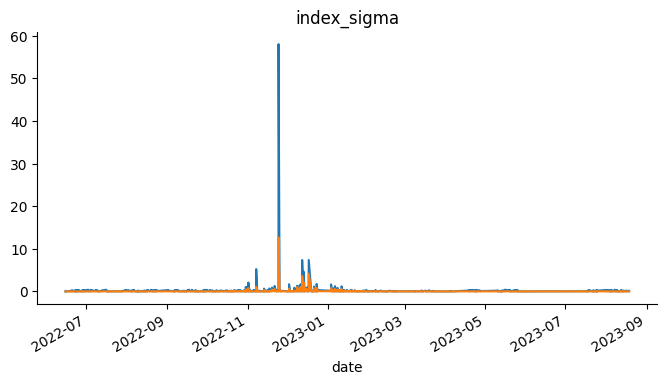

In [27]:
from matplotlib import pyplot as plt
df_filtered['index_coimbra'].plot(kind='line', figsize=(8, 4), title='index_sigma')
df_filtered['index_sigma'].plot(kind='line', figsize=(8, 4), title='index_sigma')
plt.gca().spines[['top', 'right']].set_visible(False)

In [28]:
gewünschtes_datum = '2022-06-18'

gefilterte_daten = df_filtered[df_filtered.index.date == pd.to_datetime(gewünschtes_datum).date()]

In [29]:
gefilterte_daten

,index_sigma,index_coimbra,index_stein,kc
date,,,,
2022-06-18 10:00:00,0.000207,0.002151,1.158373,0.964801
2022-06-18 11:00:00,0.000554,0.003020,2.151575,0.979229
2022-06-18 12:00:00,0.000653,0.003360,1.688552,0.961645
2022-06-18 13:00:00,0.000041,0.005623,1.368237,0.960595
2022-06-18 14:00:00,0.000357,0.006302,1.142671,0.966264
2022-06-18 15:00:00,0.001036,0.008491,1.020672,0.980057


In [30]:
UVI_gefiltert = df_UVI['UVI'][df_UVI.index.date == pd.to_datetime(gewünschtes_datum).date()]

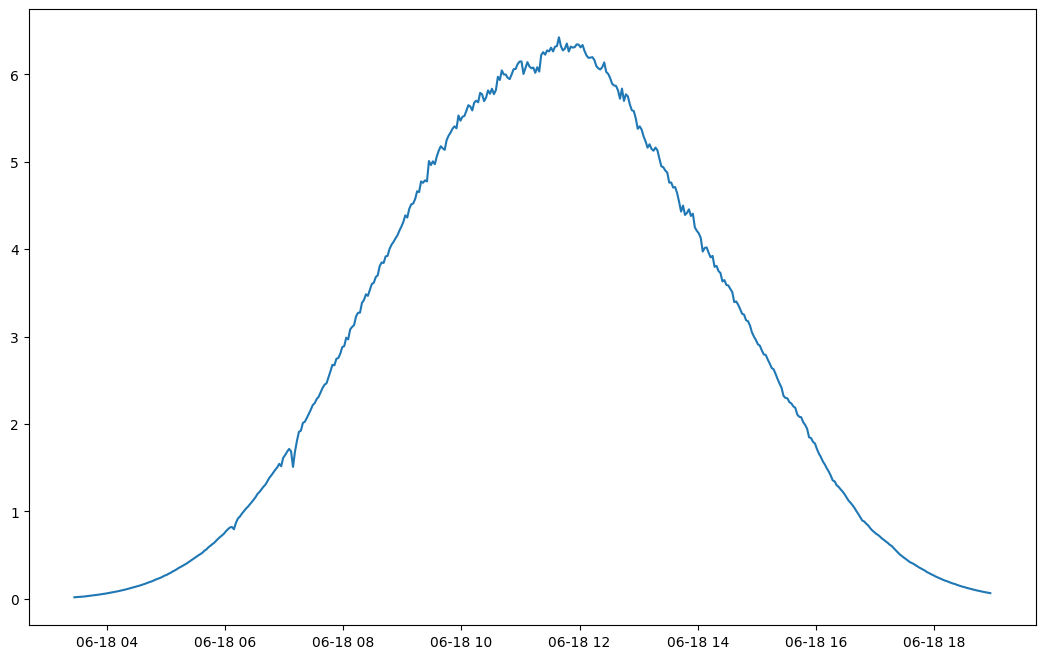

In [31]:
plt.plot(UVI_gefiltert)